# Bitcoin Prediction - FB-Prophet outperforms ARIMAX, XGBOOST and LSTM

<a href="https://www.youtube.com/watch?v=0gXeXtL_KjY&list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y&index=16"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link to my YouTube Video</b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/42xv5ii.png)](https://bit.ly/3mXnKGH "𝗕𝗶𝘁𝗰𝗼𝗶𝗻 𝗣𝗿𝗶𝗰𝗲 𝗣𝗿𝗲𝗱𝗶𝗰𝘁𝗶𝗼𝗻 𝘄𝗶𝘁𝗵 𝗗𝗲𝗲𝗽 𝗟𝗲𝗮𝗿𝗻𝗶𝗻𝗴 𝗟𝗦𝗧𝗠")


## [G-Drive Link to Dataset](https://drive.google.com/file/d/1pMqvHk4fIMSQT2HesZtvyMN3VSB_ZbRN/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima -q

# I need below fbprophet
# https://stackoverflow.com/questions/73142498/installing-fbprophet-on-colab
!pip install pystan~=2.14 -q
!pip install pystan -q
!pip install fbprophet -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')

#matplotlib inline

In [5]:
# Colab and G-drive
BTC_DF = pd.read_csv("/content/drive/MyDrive/YT-Datasets/Bitcoin-Historical-Price/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

BTC_DF.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
BTC_DF.info()

In [7]:
# Converting the Timestamp column from string to datetime
BTC_DF['Timestamp'] = [datetime.fromtimestamp(x) for x in BTC_DF['Timestamp']]

In [ ]:
BTC_DF.info()

In [9]:

BTC_DF.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
print('Dataset Shape: ',  BTC_DF.shape)

Dataset Shape:  (4857377, 8)


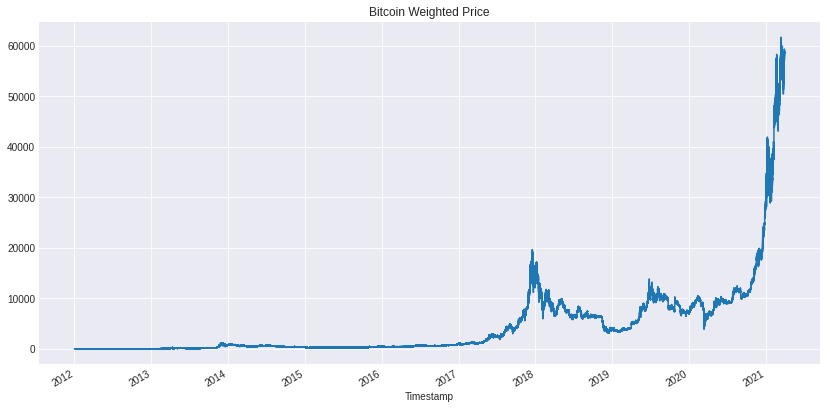

In [11]:
BTC_DF.set_index("Timestamp").Weighted_Price.plot(figsize=(14,7), title="Bitcoin Weighted Price")

In [12]:
#calculating missing values in the dataset

missing_values = BTC_DF.isnull().sum()
missing_per = (missing_values/BTC_DF.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Timestamp,0,0.00000
Open,1243608,25.60246
High,1243608,25.60246
Low,1243608,25.60246
Close,1243608,25.60246
Volume_(BTC),1243608,25.60246
Volume_(Currency),1243608,25.60246
Weighted_Price,1243608,25.60246


In [13]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()

    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()

    print(df.head())
    print(df.isnull().sum())

In [14]:
fill_missing(BTC_DF)

            Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00  4.39  4.39  4.39   4.39      0.555046   
2 2011-12-31 07:54:00  4.39  4.39  4.39   4.39      0.654511   
3 2011-12-31 07:55:00  4.39  4.39  4.39   4.39      0.753977   
4 2011-12-31 07:56:00  4.39  4.39  4.39   4.39      0.853442   

   Volume_(Currency)  Weighted_Price  
0           2.000000            4.39  
1           2.436653            4.39  
2           2.873305            4.39  
3           3.309958            4.39  
4           3.746611            4.39  
Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


In [15]:
#created a copy 
bitstamp_non_indexed = BTC_DF.copy()

In [16]:
BTC_DF = BTC_DF.set_index('Timestamp')
BTC_DF.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39


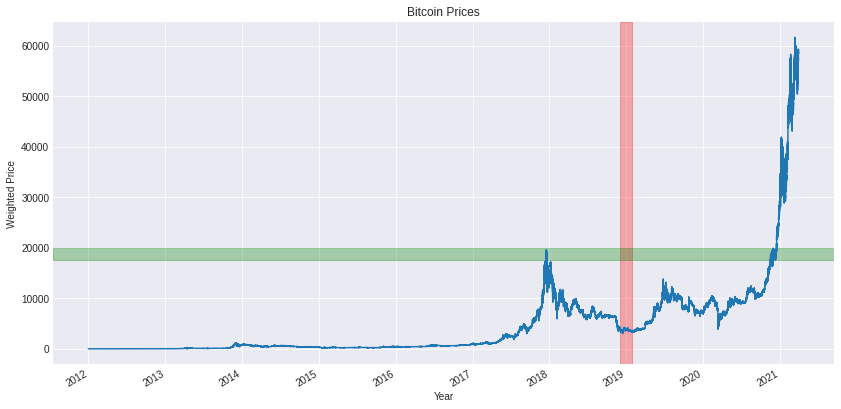

In [17]:
ax = BTC_DF['Weighted_Price'].plot(title='Bitcoin Prices', grid=True, figsize=(14,7))
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Price')

ax.axvspan('2018-12-01','2019-01-31',color='red', alpha=0.3)
ax.axhspan(17500,20000, color='green',alpha=0.3)

Text(0, 0.5, 'Weighted_Price')

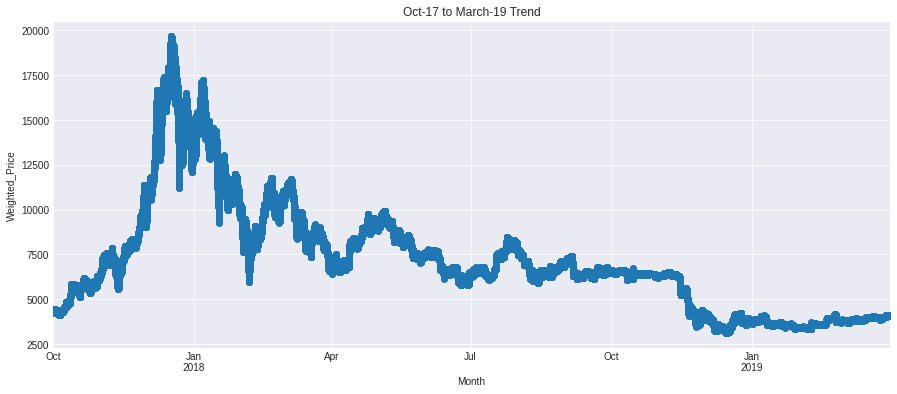

In [18]:
#Zooming in

ax = BTC_DF.loc['2017-10':'2019-03','Weighted_Price'].plot(marker='o', linestyle='-',figsize=(15,6), title="Oct-17 to March-19 Trend", grid=True)
ax.set_xlabel('Month')
ax.set_ylabel('Weighted_Price')

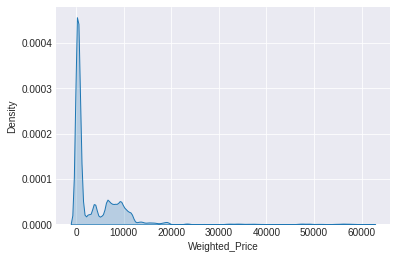

In [19]:
sns.kdeplot(BTC_DF['Weighted_Price'], shade=True)

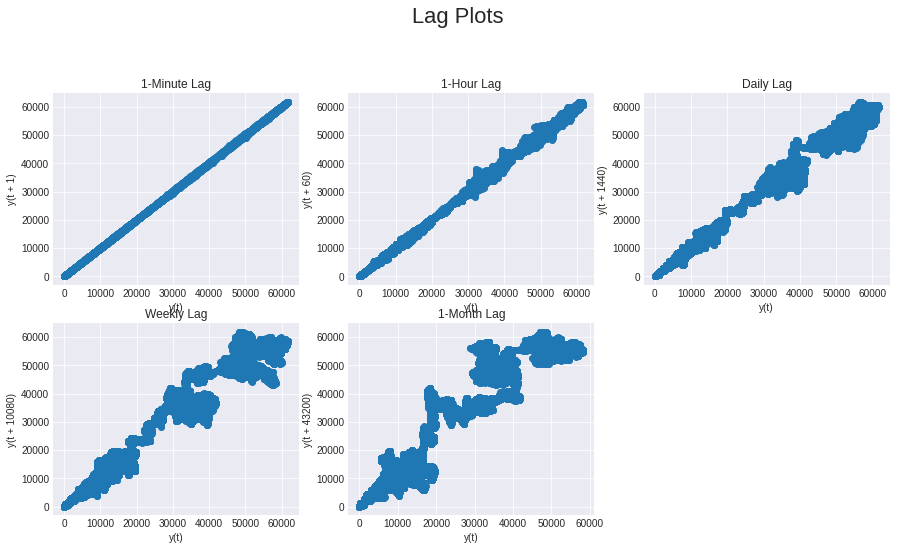

In [20]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [21]:
hourly_data = BTC_DF.resample('1H').mean()
hourly_data = hourly_data.reset_index()

hourly_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:00:00,4.39,4.39,4.39,4.39,0.803709,3.528285,4.39
1,2011-12-31 08:00:00,4.39,4.39,4.39,4.39,4.185530,18.374477,4.39
2,2011-12-31 09:00:00,4.39,4.39,4.39,4.39,10.153449,44.573640,4.39
3,2011-12-31 10:00:00,4.39,4.39,4.39,4.39,16.121368,70.772803,4.39
4,2011-12-31 11:00:00,4.39,4.39,4.39,4.39,22.089286,96.971967,4.39


In [22]:
BTC_Price_daily = BTC_DF.resample("24H").mean() #daily resampling

In [23]:
import plotly.express as px

BTC_Price_daily.reset_index(inplace=True)
fig = px.line(BTC_Price_daily, x='Timestamp', y='Weighted_Price', title='Weighted Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            
        ])
    )
)
fig.show()

In [24]:
plot_ = BTC_Price_daily.set_index("Timestamp")["2017-12"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [25]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['Open'],
                    high=plot_['High'],
                    low=plot_['Low'],
                    close=plot_['Close']))
fig.show()

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [27]:
fill_missing(BTC_Price_daily)

   Timestamp      Open      High       Low     Close  Volume_(BTC)  \
0 2011-12-31  4.476415  4.478946  4.476415  4.478946     17.940426   
1 2012-01-01  4.765576  4.765576  4.765576  4.765576      6.790640   
2 2012-01-02  5.006549  5.006549  5.006549  5.006549     15.183373   
3 2012-01-03  5.206530  5.206530  5.206530  5.206530      7.917041   
4 2012-01-04  5.202511  5.241699  5.202511  5.241699     13.659736   

   Volume_(Currency)  Weighted_Price  
0          79.495594        4.477370  
1          32.971105        4.765576  
2          75.932706        5.006549  
3          40.795994        5.206530  
4          72.860096        5.216680  
Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


In [28]:
BTC_Price_daily.Weighted_Price

0           4.477370
1           4.765576
2           5.006549
3           5.206530
4           5.216680
            ...     
3374    55192.259741
3375    55833.589719
3376    56910.365453
3377    58346.023547
3378    58764.349363
Name: Weighted_Price, Length: 3379, dtype: float64

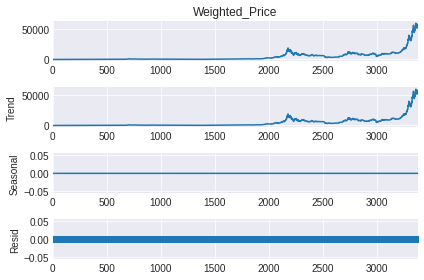

<Figure size 1080x864 with 0 Axes>

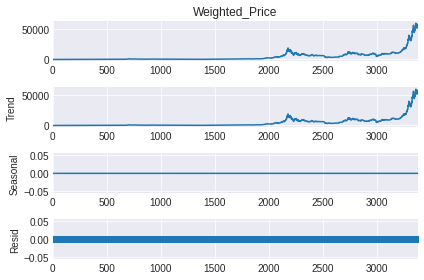

In [29]:
plt.figure(figsize=(15,12))
series = BTC_Price_daily.Weighted_Price
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

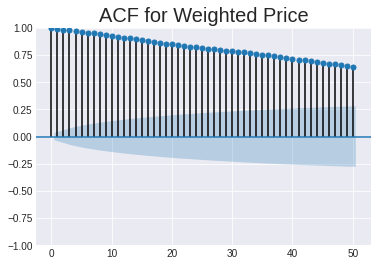

In [30]:
acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Weighted Price", size=20)
plt.show()

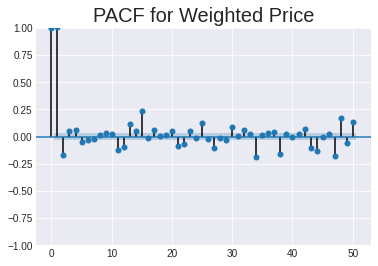

In [31]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Weighted Price", size=20)
plt.show()

In [32]:
stats, p, lags, critical_values = kpss(series, 'ct')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [33]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.6463360059696726
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


In [34]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print("dftest: ", dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
    if p > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [35]:
adf_test(series)

Results of Dickey-Fuller Test:
dftest:  (6.189943678624067, 1.0, 29, 3349, {'1%': -3.432304111473485, '5%': -2.862403412310526, '10%': -2.56722961145352}, 48557.65804172438)
Test Statistic                    6.189944
p-value                           1.000000
#Lags Used                       29.000000
Number of Observations Used    3349.000000
Critical Value (1%)              -3.432304
Critical Value (5%)              -2.862403
Critical Value (10%)             -2.567230
dtype: float64
Series is Stationary


In [36]:
df = BTC_Price_daily.set_index("Timestamp")

In [37]:
df.reset_index(drop=False, inplace=True)

rolling_features = ["Open", "High", "Low", "Close","Volume_(BTC)"]
window1 = 3
window2 = 7
window3 = 30

# First convert our original df to a rolling df of 3d, 7d  and 30d
df_rolled_3d = df[rolling_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[rolling_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[rolling_features].rolling(window=window3, min_periods=0)


# dataframe.shift() function Shift index by desired number of periods. It takes a scalar parameter called the period,
# which represents the number of shifts to be made over the desired axis. It defaults to 1 and
# it is shifting values vertically along the axis 0 . NaN will be filled for missing values introduced as a result of the shifting.
# Very helpful when dealing with time-series data.
# https://towardsdatascience.com/all-the-pandas-shift-you-should-know-for-data-analysis-791c1692b5e
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()


# Just print to see the structure of one of them
df_mean_30d

,index,Open,High,Low,Close,Volume_(BTC)
0,0,NaN,NaN,NaN,NaN,NaN
1,1,4.476415,4.478946,4.476415,4.478946,17.940426
2,2,4.620996,4.622261,4.620996,4.622261,12.365533
3,3,4.749513,4.750357,4.749513,4.750357,13.304813
4,4,4.863768,4.864400,4.863768,4.864400,11.957870
...,...,...,...,...,...,...
3374,3374,53246.117049,53284.732343,53207.410161,53247.214779,3.837317
3375,3375,53419.535306,53457.398134,53381.755430,53420.743065,3.714545
3376,3376,53725.322111,53761.831591,53688.974543,53726.542964,3.574554
3377,3377,54051.215359,54087.598046,54015.072612,54052.421612,3.627518


In [38]:
df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()

# Just print to see the structure of one of them
df_std_30d

,index,Open,High,Low,Close,Volume_(BTC)
0,0,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN
2,2,0.204468,0.202678,0.204468,0.202678,7.884089
3,3,0.265431,0.264130,0.265431,0.264130,5.807423
4,4,0.314937,0.313900,0.314937,0.313900,5.453543
...,...,...,...,...,...,...
3374,3374,4424.512839,4422.633794,4426.336478,4424.587239,1.227977
3375,3375,4394.326440,4392.541182,4395.997089,4394.356574,1.239981
3376,3376,4223.641753,4223.090719,4224.000160,4223.666478,1.251745
3377,3377,4072.023486,4071.241792,4072.595029,4072.035724,1.222073


In [39]:
for feature in rolling_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Timestamp", drop=False, inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,4568.640649,4535.780516,...,4345.881445,112.744372,185.758045,417.825217,9.579974,9.586140,9.601214,3.444517,4.196693,5.179093
2012-01-01,2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.476415,4.476415,...,4.478946,112.744372,185.758045,417.825217,17.940426,17.940426,17.940426,3.444517,4.196693,5.179093
2012-01-02,2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,4.620996,4.620996,...,4.622261,0.202678,0.202678,0.202678,12.365533,12.365533,12.365533,7.884089,7.884089,7.884089
2012-01-03,2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,4.749513,4.749513,...,4.750357,0.264130,0.264130,0.264130,13.304813,13.304813,13.304813,5.807423,5.807423,5.807423
2012-01-04,2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,4.992885,4.863768,...,4.864400,0.220794,0.313900,0.313900,9.963685,11.957870,11.957870,4.555332,5.453543,5.453543


In [40]:
df["month"] = df.Timestamp.dt.month
df["week"] = df.Timestamp.dt.week
df["day"] = df.Timestamp.dt.day
df["day_of_week"] = df.Timestamp.dt.dayofweek
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30,month,week,day,day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,4568.640649,4535.780516,...,9.579974,9.586140,9.601214,3.444517,4.196693,5.179093,12,52,31,5
2012-01-01,2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.476415,4.476415,...,17.940426,17.940426,17.940426,3.444517,4.196693,5.179093,1,52,1,6
2012-01-02,2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,4.620996,4.620996,...,12.365533,12.365533,12.365533,7.884089,7.884089,7.884089,1,1,2,0
2012-01-03,2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,4.749513,4.749513,...,13.304813,13.304813,13.304813,5.807423,5.807423,5.807423,1,1,3,1
2012-01-04,2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,4.992885,4.863768,...,9.963685,11.957870,11.957870,4.555332,5.453543,5.453543,1,1,4,2


In [41]:
df_train = df[df.Timestamp < "2020"]
df_valid = df[df.Timestamp >= "2020"]

print('train shape :', df_train.shape)
print('validation shape :', df_valid.shape)

train shape : (2923, 42)
validation shape : (456, 42)


# ARIMAX

In [42]:
import pmdarima as pm

In [43]:
# From df.columns, I remove all the original 8 columns i.e 
# 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price',
# So I will be left with below newly created (engineered) columns
# Also 

exogenous_features = ['Open_mean_lag3',
       'Open_mean_lag7', 'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7',
       'Open_std_lag30', 'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30', 'Close_mean_lag3', 'Close_mean_lag7',
       'Close_mean_lag30', 'Close_std_lag3', 'Close_std_lag7',
       'Close_std_lag30', 'Volume_(BTC)_mean_lag3', 'Volume_(BTC)_mean_lag7',
       'Volume_(BTC)_mean_lag30', 'Volume_(BTC)_std_lag3',
       'Volume_(BTC)_std_lag7', 'Volume_(BTC)_std_lag30', 'month', 'week',
       'day', 'day_of_week']

# len(exogenous_features1) # 34

In [44]:
model = pm.auto_arima(df_train.Weighted_Price, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)


model.fit(df_train.Weighted_Price, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])

df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=38681.246, Time=2.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38822.318, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38712.337, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38716.835, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38820.833, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=38679.580, Time=2.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38712.751, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38714.288, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=38681.295, Time=3.01 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=38711.116, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=38716.332, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=38682.840, Time=5.71 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=38677.845, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38711.084, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



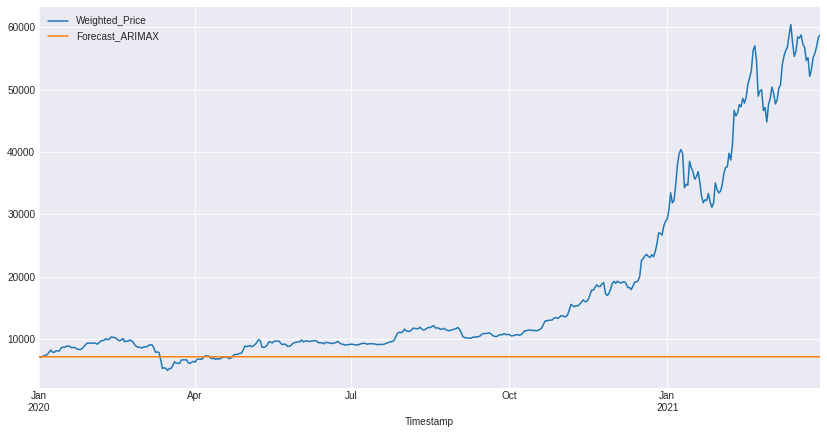

In [45]:
df_valid[["Weighted_Price", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Weighted_Price, df_valid.Forecast_ARIMAX)))

print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Weighted_Price, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 18100.140904413514

MAE of Auto ARIMAX: 10733.36863799476


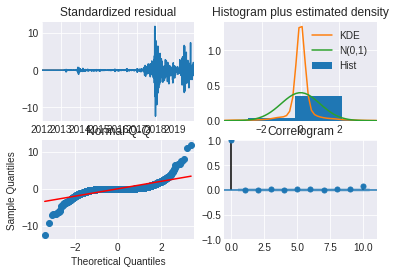

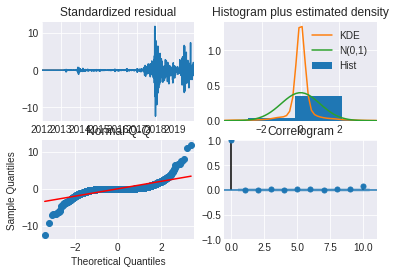

In [47]:
model.plot_diagnostics()

# FB Prophet

In [48]:
from fbprophet import Prophet

In [49]:
# Resampling originial data to day level and forward fill the missing values
daily_data = BTC_DF.resample("24H").mean() #daily resampling
fill_missing(daily_data)

                Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                          
2011-12-31  4.476415  4.478946  4.476415  4.478946     17.940426   
2012-01-01  4.765576  4.765576  4.765576  4.765576      6.790640   
2012-01-02  5.006549  5.006549  5.006549  5.006549     15.183373   
2012-01-03  5.206530  5.206530  5.206530  5.206530      7.917041   
2012-01-04  5.202511  5.241699  5.202511  5.241699     13.659736   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31          79.495594        4.477370  
2012-01-01          32.971105        4.765576  
2012-01-02          75.932706        5.006549  
2012-01-03          40.795994        5.206530  
2012-01-04          72.860096        5.216680  
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


In [50]:
# Renaming the column names according to Prophet's requirements

daily_data_fb = daily_data.reset_index()[['Timestamp','Weighted_Price']].rename({'Timestamp':'ds','Weighted_Price':'y'}, axis=1)
daily_data_fb.head()

,ds,y
0,2011-12-31,4.477370
1,2012-01-01,4.765576
2,2012-01-02,5.006549
3,2012-01-03,5.206530
4,2012-01-04,5.216680


In [51]:
split_date = "2020-01-01"
train_split = daily_data_fb['ds'] <= split_date
test_split = daily_data_fb['ds'] > split_date

train_fb = daily_data_fb[train_split]
test_fb = daily_data_fb[test_split]

In [52]:
print("train data shape :", train_fb.shape)
print("test data shape :", test_fb.shape)

train data shape : (2924, 2)
test data shape : (455, 2)


In [53]:
model_fbprophet = Prophet()
for feature in exogenous_features:
    model_fbprophet.add_regressor(feature)

model_fbprophet.fit(df_train[["Timestamp", "Weighted_Price"] + exogenous_features].rename(columns={"Timestamp": "ds", "Weighted_Price": "y"}))

forecast = model_fbprophet.predict(df_valid[["Timestamp", "Weighted_Price"] + exogenous_features].rename(columns={"Timestamp": "ds"}))

forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Close_mean_lag3,Close_mean_lag3_lower,Close_mean_lag3_upper,Close_mean_lag30,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,2699.606023,7111.376460,7719.655990,2699.606023,2699.606023,6374.198252,6374.198252,6374.198252,-39.990387,...,0.697852,0.697852,0.697852,-60.652776,-60.652776,-60.652776,0.0,0.0,0.0,7415.680567
1,2020-01-02,2699.687084,7052.497217,7642.410300,2699.687084,2699.687084,6307.195276,6307.195276,6307.195276,-39.958258,...,-8.920954,-8.920954,-8.920954,-81.505998,-81.505998,-81.505998,0.0,0.0,0.0,7345.797337
2,2020-01-03,2699.768145,6892.917966,7498.365882,2699.768145,2699.768145,6206.122481,6206.122481,6206.122481,-39.888945,...,-8.558370,-8.558370,-8.558370,-101.546849,-101.546849,-101.546849,0.0,0.0,0.0,7207.140225
3,2020-01-04,2699.849206,6939.044963,7568.661418,2699.849206,2699.849206,6214.582371,6214.582371,6214.582371,-39.872522,...,10.995445,10.995445,10.995445,-120.634216,-120.634216,-120.634216,0.0,0.0,0.0,7259.624994
4,2020-01-05,2699.930267,6922.981029,7550.592862,2699.930267,2699.930267,6271.125003,6271.125003,6271.125003,-39.870714,...,2.370675,2.370675,2.370675,-138.643972,-138.643972,-138.643972,0.0,0.0,0.0,7242.214593


In [54]:
df_valid["Forecast_Prophet"] = forecast.yhat.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



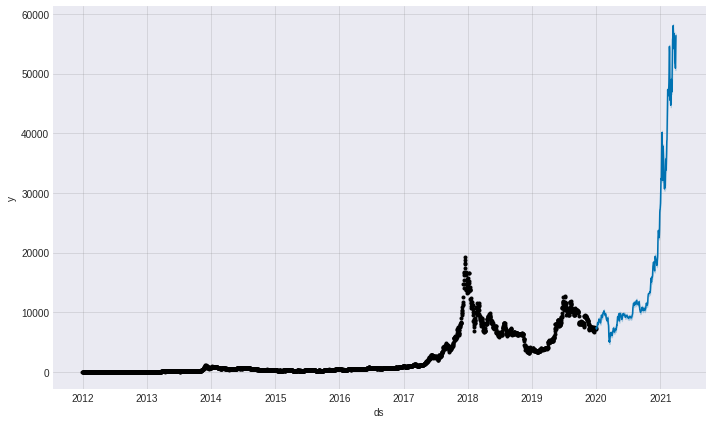

In [55]:
# Plot Our Predictions
fig1 = model_fbprophet.plot(forecast)

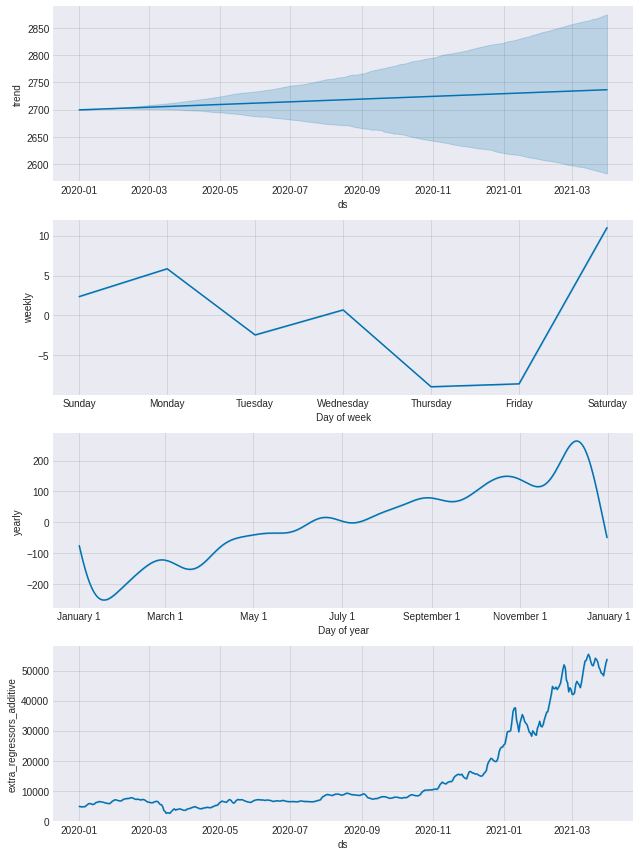

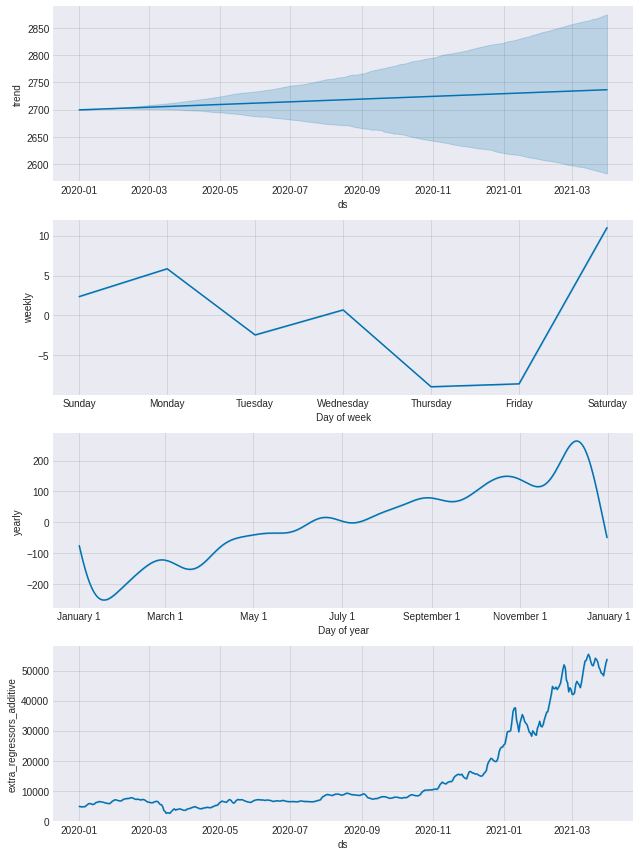

In [56]:
model_fbprophet.plot_components(forecast)

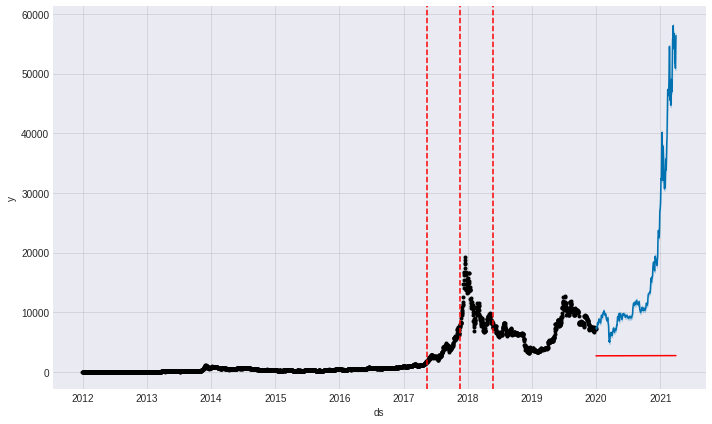

In [57]:
# Plotting changepoints
from fbprophet.plot import add_changepoints_to_plot

fig = model_fbprophet.plot(forecast)

a = add_changepoints_to_plot(fig.gca(), model_fbprophet, forecast)

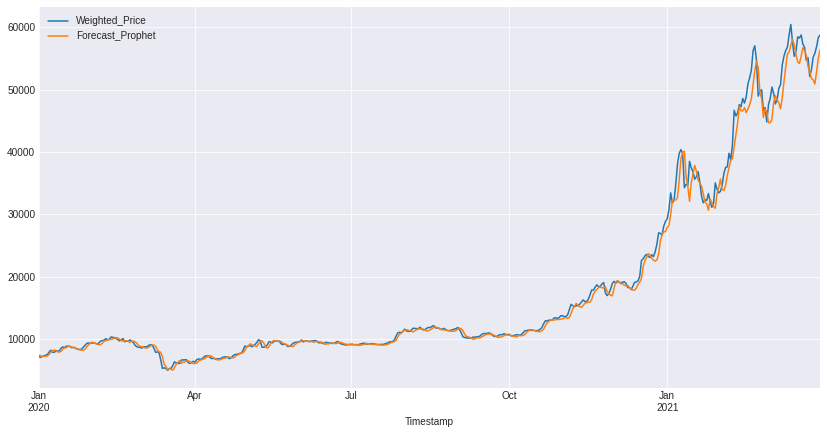

In [58]:
df_valid[["Weighted_Price", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [59]:
test_mae_prophet = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet'])

test_rmse_prophet = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet']))

print(f"Prophet's Test MAE : {test_mae_prophet}")
print(f"Prophet's Test RMSE : {test_rmse_prophet}")

Prophet's Test MAE : 690.3422901134225
Prophet's Test RMSE : 1308.4456706583592


# XGBOOST

In [60]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [61]:
X_train, y_train = df_train[exogenous_features], df_train.Weighted_Price
X_test, y_test = df_valid[exogenous_features], df_valid.Weighted_Price

In [62]:
reg = xgb.XGBRegressor()

In [63]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [64]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [65]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[10:11:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.6, 0.7,
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [1, 3, 4, 5, 6, 7],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                

In [66]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : -3.1553592524008023
Model Best Parameters : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.5, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.4, 'importance_type': 'gain', 'learning_rate': 0.2, 'max_delta_step': 0, 'max_depth': 1, 'min_child_weight': 12, 'missing': None, 'n_estimators': 944, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.7, 'verbosity': 1}


In [67]:
model.best_estimator_

XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=0.4,
             learning_rate=0.2, max_depth=1, min_child_weight=12,
             n_estimators=944, subsample=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



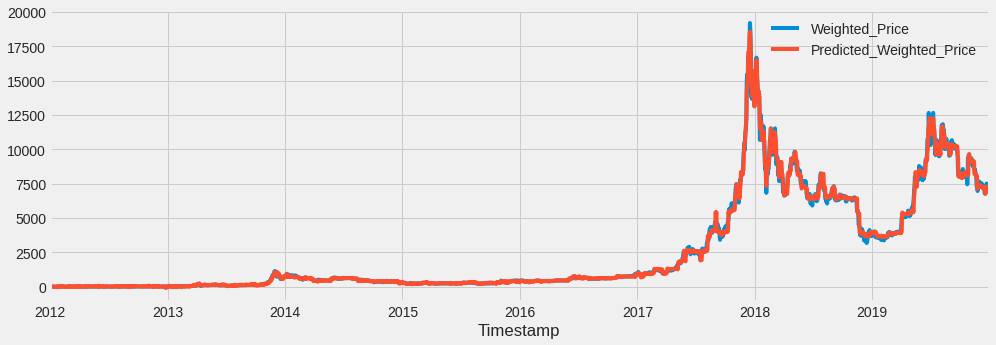

In [68]:
df_train['Predicted_Weighted_Price'] = model.predict(X_train)

df_train[['Weighted_Price','Predicted_Weighted_Price']].plot(figsize=(15, 5))

In [69]:
df_valid['Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([df_train, df_valid], sort=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



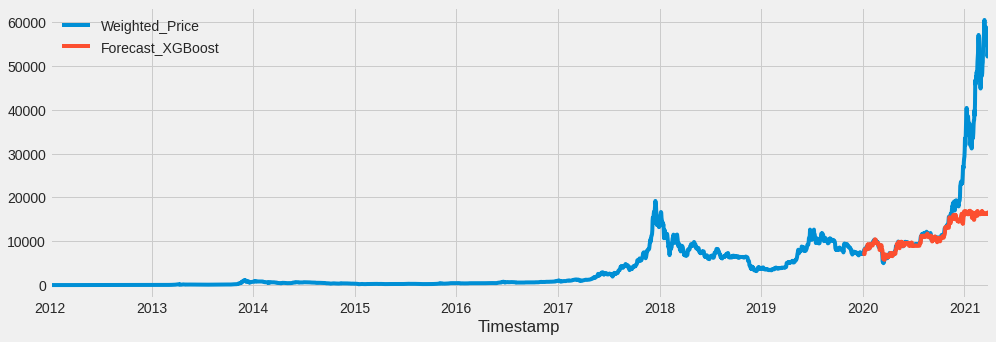

In [70]:
overall_data[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

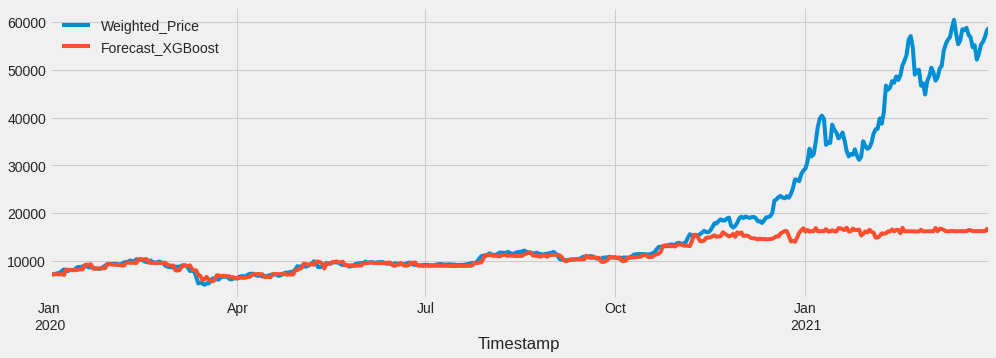

In [71]:
df_valid[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [73]:
train_mae_xgboost = mean_absolute_error(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price'])
train_rmse_xgboost = np.sqrt(mean_squared_error(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price']))
train_r_square_xgboost = r2_score(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price'])

print(f"train MAE : {train_mae_xgboost}")
print(f"train RMSE : {train_rmse_xgboost}")
print(f"train R2 : {train_r_square_xgboost}")

train MAE : 101.57382667376154
train RMSE : 210.87246862026365
train R2 : 0.9965562027566682


In [74]:
test_mae_xgboost = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])
test_rmse_xgboost = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost']))
test_r2_xgboost = r2_score(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])

print(f"test MAE XGBOOST : {test_mae_xgboost}")
print(f"test RMSE XGBOOST : {test_rmse_xgboost}")
print(f"test R2 XGBOOST : {test_r2_xgboost}")

test MAE XGBOOST : 6505.047951105817
test RMSE XGBOOST : 13626.380880094044
test R2 XGBOOST : 0.13662927363209065


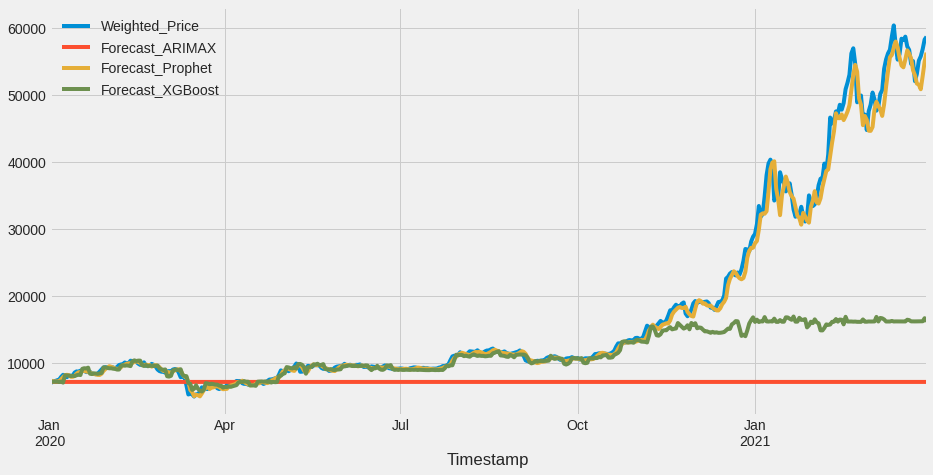

In [75]:
df_valid[["Weighted_Price", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_XGBoost"]].plot(figsize=(14,7))

In [76]:
arimax_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_ARIMAX']))

fbp_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet']))

xgb_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost']))

# MAE

arimax_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_ARIMAX'])
fbp_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet'])
xgb_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])


print("ARIMAX RMSE :", arimax_rmse)
print("FB Prophet RMSE :", fbp_rmse)
print("XGBoost RMSE :", xgb_rmse)

print("\nARIMAX MAE :", arimax_mae)
print("FB Prophet MAE :", fbp_mae)
print("XGBoost MAE :", xgb_mae)

ARIMAX RMSE : 18100.140904413514
FB Prophet RMSE : 1308.4456706583592
XGBoost RMSE : 13626.380880094044

ARIMAX MAE : 10733.36863799476
FB Prophet MAE : 690.3422901134225
XGBoost MAE : 6505.047951105817


# LSTM

In [77]:
price_series = BTC_Price_daily.reset_index().Weighted_Price.values
price_series

array([4.47737025e+00, 4.76557639e+00, 5.00654859e+00, ...,
       5.69103655e+04, 5.83460235e+04, 5.87643494e+04])

In [78]:
# Lets check what was the split of earlier train and test dataset
df_train.shape # (2923, 43)

(2923, 43)

In [79]:

train_data, test_data = price_series[0:2923], price_series[2923:]

In [80]:
# Feature Scaling
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range = (0, 1))

# price_series_scaled = scaler.fit_transform(price_series.reshape(-1,1))

In [81]:


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))

train_data = scaler.fit_transform(train_data.reshape(-1,1))

test_data = scaler.transform(test_data.reshape(-1,1))

In [82]:
# train_data, test_data = price_series_scaled[0:2923], price_series_scaled[2923:]

In [83]:
train_data.shape, test_data.shape

((2923, 1), (456, 1))

In [84]:
def get_window_ds_list_for_lstm(series, time_step):
    # Here, basically for each window, all data upto the last but one data-point
    # will be appended to as X variable and then
    # the last data-point of that window will be the Y variable (i.e. target)
    dataX, dataY = [], []
    for i in range(len(series)- time_step-1):
        a = series[i : (i+time_step), 0]
        dataX.append(a)
        b = series[i + time_step, 0]
        dataY.append(b)
        
    return np.array(dataX), np.array(dataY)

In [85]:
X_train, y_train = get_window_ds_list_for_lstm(train_data, time_step=100)
X_test, y_test = get_window_ds_list_for_lstm(test_data, time_step=100)

In [86]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2822, 100), (2822,), (355, 100), (355,))

In [87]:
#reshape inputs to be [samples, timesteps, features] which is requred for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


print(X_train.shape) 
print(X_test.shape)

(2822, 100, 1)
(355, 100, 1)


In [88]:
print(y_train.shape) 
print(y_test.shape)

(2822,)
(355,)


In [89]:
#Create Stacked LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [90]:
# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [91]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [92]:
# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, validation_split=0.1, epochs = 50, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/50
80/80 [==============================] - 14s 41ms/step - loss: 0.0072 - val_loss: 0.0664
Epoch 2/50
80/80 [==============================] - 2s 19ms/step - loss: 0.0189 - val_loss: 0.0417
Epoch 3/50
80/80 [==============================] - 2s 20ms/step - loss: 0.0186 - val_loss: 0.0081
Epoch 4/50
80/80 [==============================] - 2s 19ms/step - loss: 0.0216 - val_loss: 0.0048
Epoch 5/50
80/80 [==============================] - 2s 20ms/step - loss: 0.0124 - val_loss: 0.0061
Epoch 6/50
80/80 [==============================] - 2s 19ms/step - loss: 0.0085 - val_loss: 0.0045
Epoch 7/50
80/80 [==============================] - 2s 20ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 8/50
80/80 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 9/50
80/80 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 10/50
80/80 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 11

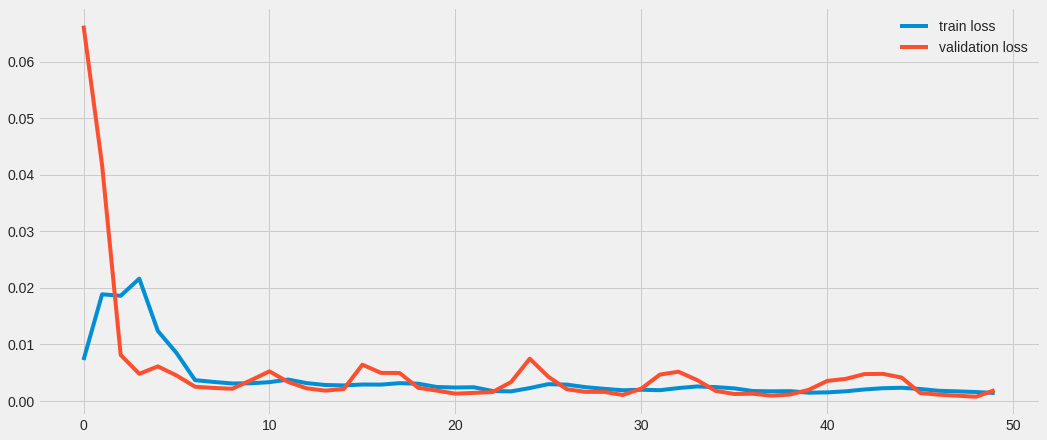

In [93]:
plt.figure(figsize=(16,7))
plt.plot(history.history["loss"], label= "train loss")
plt.plot(history.history["val_loss"], label= "validation loss")
plt.legend()

In [94]:
#Lets do the prediction and performance checking

train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [95]:
#transformation to original form

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

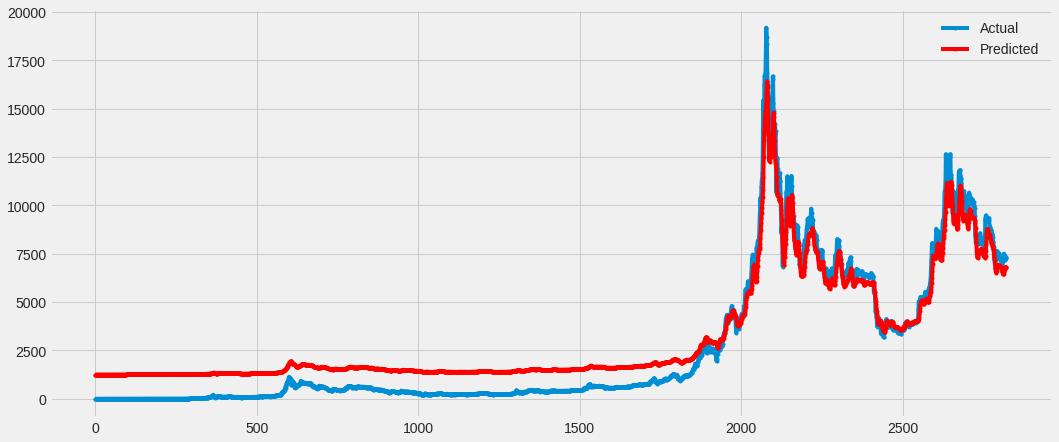

In [96]:
plt.figure(figsize=(16,7))
plt.plot(y_train_inv.flatten(), marker='.', label="Actual")
plt.plot(train_predict_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()

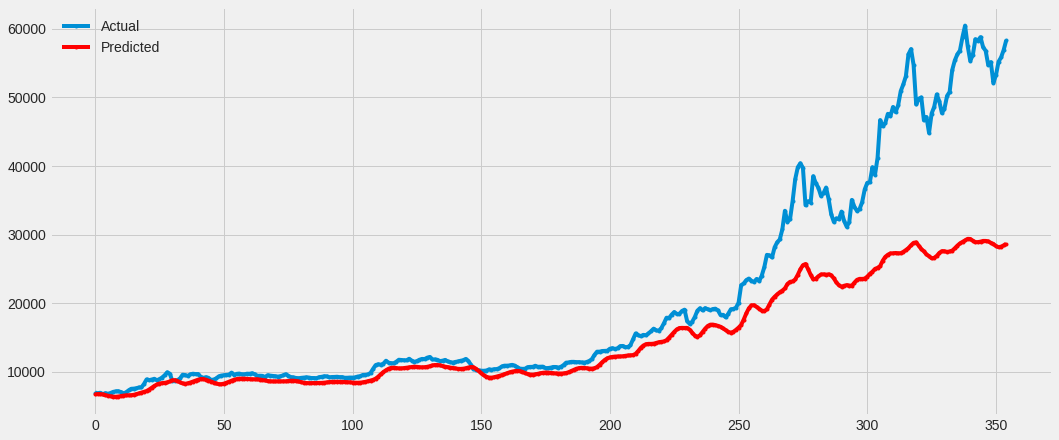

In [97]:
plt.figure(figsize=(16,7))
plt.plot(y_test_inv.flatten(), marker='.', label="Actual")
plt.plot(test_predict_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()

In [ ]:
train_RMSE_inverse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_RMSE_inverse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

train_MAE_inverse = mean_squared_error(y_train_inv, train_predict_inv )
test_MAE_inverse = mean_squared_error(y_test_inv, test_predict_inv )


print(f"Train RMSE Inverse: {train_RMSE_inverse}")
print(f"Train MAE Inverse: {train_MAE_inverse}")

print(f"Test RMSE Inverse: {test_RMSE_inverse}")
print(f"Test MAE Inverse: {test_MAE_inverse}")

Train RMSE Inverse: 1016.1695287406345

Train MAE Inverse: 925.4979757121519

Test RMSE Inverse: 10222.953847536348

Test MAE Inverse: 5767.259761183345